# Titanic 생존 예측 — 블럭 기반 파이프라인

아래 노트북은 사용자의 기존 코드 스타일(한글 주석, Malgun Gothic 폰트, 컬러풀한 시각화, 블럭 헤더)을 반영해, 전처리→피처선정→모델학습→튜닝까지 순차적으로 실행할 수 있도록 구성했습니다.

**구성:**
1) 공통 임포트/설정
2) 데이터 준비 + 다결측/중복 컬럼 삭제
3) `age` 결측: class별 중앙값 대체
4) 그 외 결측: 수치=평균, 범주/불리언=최빈값
5) 이상치 IQR 윈저화: `age`, `fare_per_person`
6) 피처 중요도: 상관 + Mutual Information
7) Baseline 모델 3종(KNN/Logistic/DecisionTree) 비교
8) 튜닝(GridSearchCV + RepeatedStratifiedKFold, 정밀도 우선)
9) 임계값 F0.5 최적화 & 혼동행렬


In [1]:

# =========================================================
# [Block 0] 공통 임포트 & 전역 설정
# - 한글 폰트: Malgun Gothic
# - 경고 무시, 랜덤시드 고정
# - 인코딩 이슈 방지 (한글 출력)
# =========================================================

import sys, io, warnings, os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

warnings.filterwarnings('ignore')

# 출력 인코딩(윈도우 콘솔 이슈 방지)
try:
    sys.stdout.reconfigure(encoding='utf-8')  # type: ignore[attr-defined]
    sys.stderr.reconfigure(encoding='utf-8')  # type: ignore[attr-defined]
except Exception:
    if hasattr(sys.stdout, "buffer"):
        sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')
    if hasattr(sys.stderr, "buffer"):
        sys.stderr = io.TextIOWrapper(sys.stderr.buffer, encoding='utf-8')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 색상 팔레트(필요 시 변경)
PALETTE_A = "Spectral"
PALETTE_B = "viridis"
COLOR_TAB10 = sns.color_palette("tab10")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 데이터 로드 (Seaborn 내장 Titanic)
import seaborn as sns
titanic = sns.load_dataset('titanic')
df = titanic.copy()

print("✅ 원본 df.shape:", df.shape)
display(df.head())


✅ 원본 df.shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


🔎 결측률 상위 15개 컬럼


,missing_%
deck,77.2
age,19.9
embarked,0.2
embark_town,0.2
sex,0.0
pclass,0.0
survived,0.0
fare,0.0
parch,0.0
sibsp,0.0


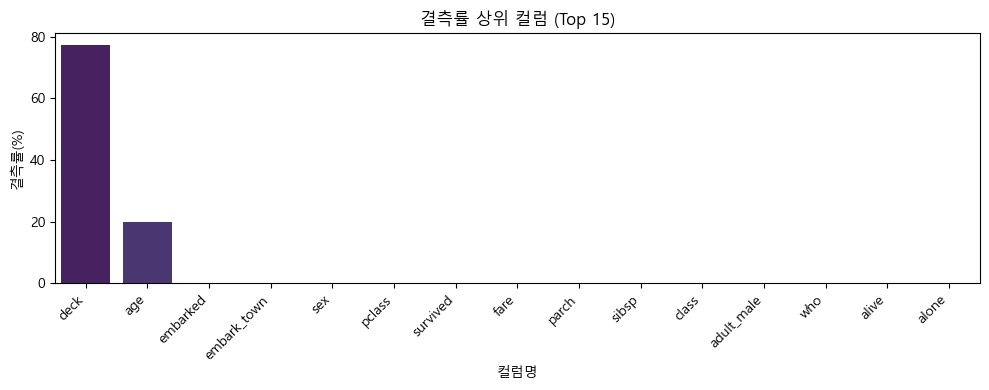

🧹 삭제한 컬럼: ['deck', 'alive', 'embark_town']
📐 df.shape(after drop): (891, 12)


In [2]:

# =========================================================
# [Block 1] 다결측/중복 컬럼 삭제 + 결측률 점검
# - 삭제: deck, alive, embark_town (embarked는 유지)
# =========================================================

# 결측률 확인
missing_ratio = (df.isna().mean() * 100).sort_values(ascending=False).round(1)
print("🔎 결측률 상위 15개 컬럼")
display(missing_ratio.head(15).to_frame("missing_%"))

# 시각화(서브플롯): 결측률 Top 15
plt.figure(figsize=(10,4))
sns.barplot(x=missing_ratio.head(15).index, y=missing_ratio.head(15).values, palette=PALETTE_B)
plt.title("결측률 상위 컬럼 (Top 15)")
plt.ylabel("결측률(%)"); plt.xlabel("컬럼명")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# 안전 삭제
to_drop = [c for c in ["deck", "alive", "embark_town"] if c in df.columns]
df.drop(columns=to_drop, inplace=True)

print(f"🧹 삭제한 컬럼: {to_drop}")
print(f"📐 df.shape(after drop): {df.shape}")


🧮 class별 age 중앙값


class
First     37.0
Second    29.0
Third     24.0
Name: age, dtype: float64

✅ age 결측치 개수(대체 후): 0


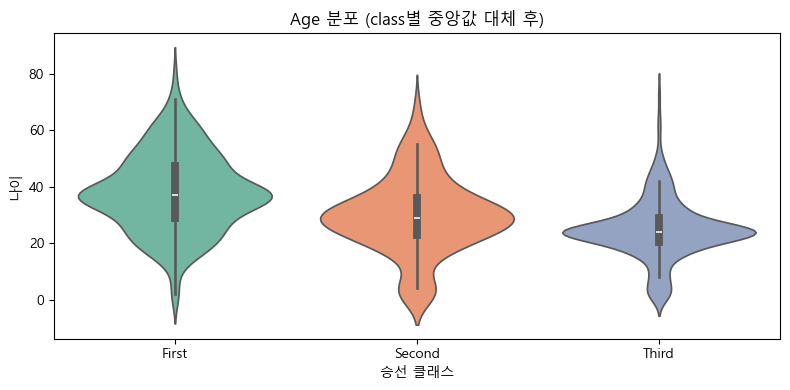

In [3]:

# =========================================================
# [Block 2] age 결측치를 class별 "중앙값"으로 대체
# =========================================================

print("🧮 class별 age 중앙값")
age_median_by_class = df.groupby('class')['age'].median()
display(age_median_by_class)

df['age'] = df['age'].fillna(df.groupby('class')['age'].transform('median'))

print("✅ age 결측치 개수(대체 후):", int(df['age'].isna().sum()))

# 분포 비교(바이올린): Before/After는 간단 확인용(여기선 After만)
plt.figure(figsize=(8,4))
sns.violinplot(data=df.dropna(subset=['age']), x='class', y='age', palette=sns.color_palette("Set2"))
plt.title('Age 분포 (class별 중앙값 대체 후)')
plt.xlabel('승선 클래스'); plt.ylabel('나이')
plt.tight_layout(); plt.show()


In [4]:

# =========================================================
# [Block 3] 그 외 결측치 처리
# - 수치형: 평균
# - 범주형/불리언: 최빈값
# =========================================================

num_cols  = df.select_dtypes(include=['number']).columns.tolist()
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
cat_cols  = df.select_dtypes(include=['object','category']).columns.tolist()

# 수치형 평균 대체
df[num_cols] = df[num_cols].fillna(df[num_cols].mean(numeric_only=True))

# 범주형/불리언 최빈값 대체
for col in (cat_cols + bool_cols):
    mode_series = df[col].mode(dropna=True)
    if len(mode_series) > 0:
        df[col] = df[col].fillna(mode_series.iloc[0])
    else:
        df[col] = df[col].fillna("Unknown" if col in cat_cols else False)

print("✅ 잔여 결측 개수 합:", int(df.isna().sum().sum()))


✅ 잔여 결측 개수 합: 0


📏 IQR 경계값: {'age': (np.float64(-0.5), np.float64(59.5)), 'fare_per_person': (np.float64(-17.375), np.float64(48.292))}


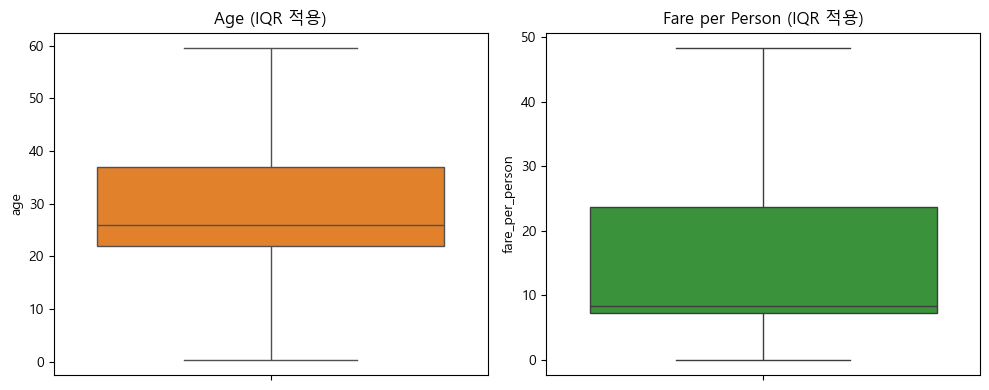

In [5]:

# =========================================================
# [Block 4] 이상치 윈저화 (IQR) — age, fare_per_person
# - 가족수 기반 인당 요금: fare / (sibsp + parch + 1)
# - IQR: [Q1-1.5*IQR, Q3+1.5*IQR]로 clip
# =========================================================

df['family_size'] = df['sibsp'] + df['parch'] + 1
df['fare_per_person'] = df['fare'] / df['family_size']

def iqr_clip(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return s.clip(lower=lower, upper=upper), (lower, upper, q1, q3)

bounds = {}
for col in ['age','fare_per_person']:
    df[col], (lo, up, q1, q3) = iqr_clip(df[col])
    bounds[col] = (lo, up, q1, q3)

print("📏 IQR 경계값:", {k: (round(v[0],3), round(v[1],3)) for k,v in bounds.items()})

# 박스플롯(서브플롯)
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y=df['age'], ax=axes[0], color=COLOR_TAB10[1]); axes[0].set_title("Age (IQR 적용)")
sns.boxplot(y=df['fare_per_person'], ax=axes[1], color=COLOR_TAB10[2]); axes[1].set_title("Fare per Person (IQR 적용)")
plt.tight_layout(); plt.show()


🧾 OHE 후 X: (891, 16)


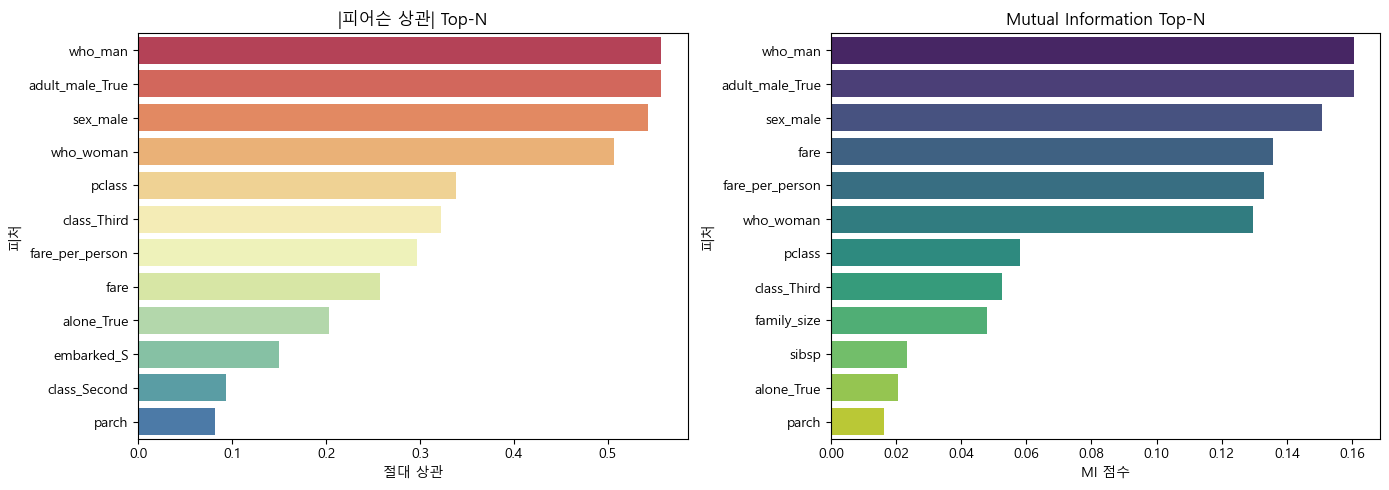

✅ 선정 피처(합집합) 개수: 14


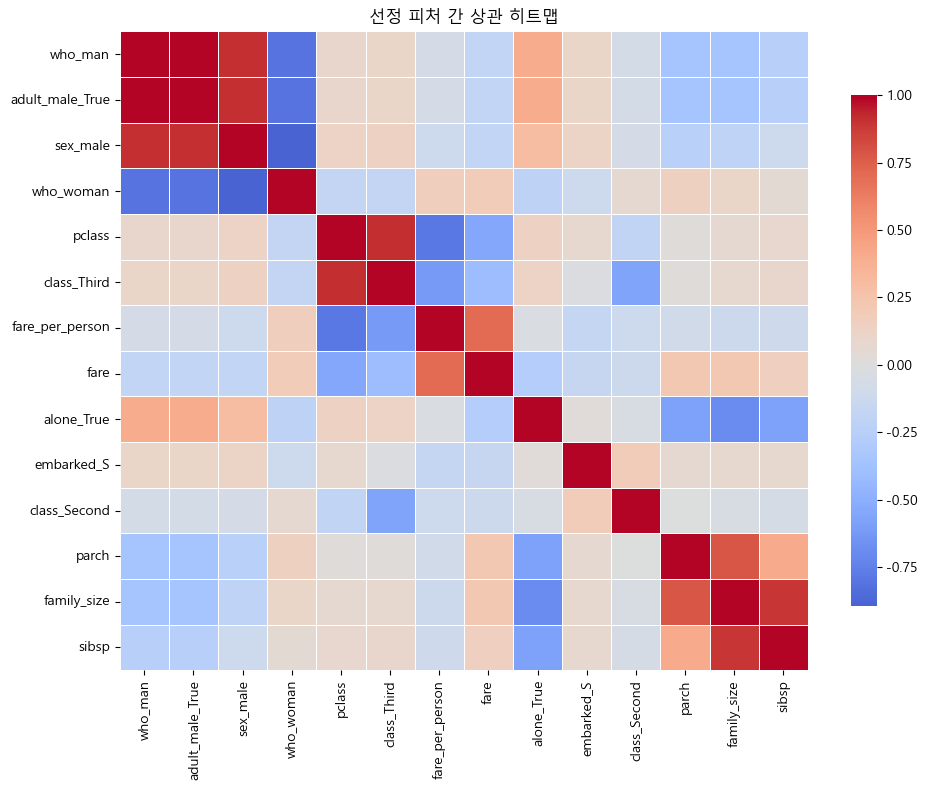

In [6]:

# =========================================================
# [Block 5] 피처 중요도 — 상관(피어슨) + Mutual Information
# - 범주형/불리언: 원-핫 인코딩(drop_first=True)
# - 상위 Top-N 비교 막대그래프 + 선정 피처 히트맵
# =========================================================

from sklearn.feature_selection import mutual_info_classif

y = df['survived'].astype(int)
drop_cols = ['survived']
base_cols = [c for c in df.columns if c not in drop_cols]

# OHE
cat_cols  = df.select_dtypes(include=['object','category']).columns.tolist()
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
X_ohe = pd.get_dummies(df[base_cols], columns=cat_cols+bool_cols, drop_first=True)
print("🧾 OHE 후 X:", X_ohe.shape)

# 피어슨 상관
corr_with_y = X_ohe.join(y).corr(numeric_only=True)['survived'].drop('survived')
corr_abs = corr_with_y.abs().sort_values(ascending=False)

TOP_N = 12
top_corr_feats = corr_abs.head(TOP_N).index.tolist()

# MI
discrete_mask = X_ohe.apply(lambda s: s.nunique() <= 10).values
mi_scores = mutual_info_classif(X_ohe.values, y.values, discrete_features=discrete_mask, random_state=RANDOM_STATE)
mi_ser = pd.Series(mi_scores, index=X_ohe.columns).sort_values(ascending=False)
top_mi_feats = mi_ser.head(TOP_N).index.tolist()

# 시각화
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x=corr_abs.head(TOP_N).values, y=corr_abs.head(TOP_N).index, ax=axes[0], palette=PALETTE_A)
axes[0].set_title("|피어슨 상관| Top-N"); axes[0].set_xlabel("절대 상관"); axes[0].set_ylabel("피처")
sns.barplot(x=mi_ser.head(TOP_N).values, y=mi_ser.head(TOP_N).index, ax=axes[1], palette=PALETTE_B)
axes[1].set_title("Mutual Information Top-N"); axes[1].set_xlabel("MI 점수"); axes[1].set_ylabel("피처")
plt.tight_layout(); plt.show()

selected_feats = list(dict.fromkeys(top_corr_feats + top_mi_feats))
print("✅ 선정 피처(합집합) 개수:", len(selected_feats))

# 히트맵
corr_mat = X_ohe[selected_feats].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat, cmap="coolwarm", center=0, linewidths=.5, cbar_kws={"shrink": .8})
plt.title("선정 피처 간 상관 히트맵")
plt.tight_layout(); plt.show()

# 다음 블록에서 사용
FEATURES_UNION = selected_feats
X_FOR_MODEL = X_ohe
Y_FOR_MODEL = y


📊 Baseline 성능 요약


,model,accuracy,roc_auc
1,Logistic,0.843575,0.864295
0,KNN,0.782123,0.811989
2,DecisionTree,0.798883,0.803755


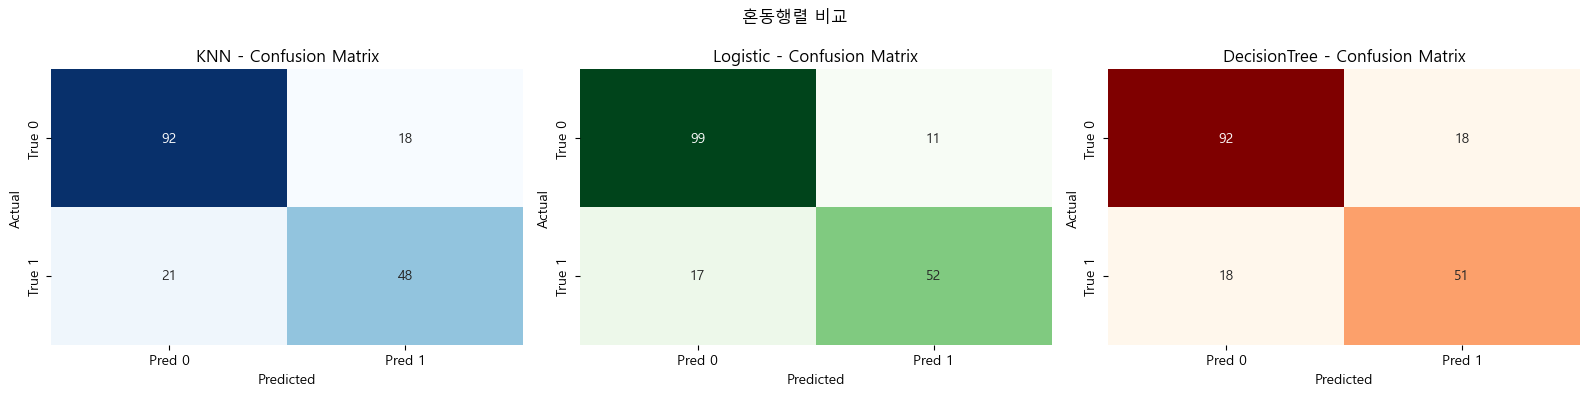

In [7]:

# =========================================================
# [Block 6] Baseline 3모델 비교
# - 피처: FEATURES_UNION
# - 스케일링: KNN/Logistic만 StandardScaler 적용, DT는 미적용
# =========================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)

feats = FEATURES_UNION
X = X_FOR_MODEL[feats].copy()
y = Y_FOR_MODEL.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
lr  = LogisticRegression(max_iter=1000, solver="lbfgs")
dt  = DecisionTreeClassifier(random_state=RANDOM_STATE)

knn.fit(X_train_scaled, y_train)
lr.fit(X_train_scaled, y_train)
dt.fit(X_train, y_train)

preds = {
    "KNN": knn.predict(X_test_scaled),
    "Logistic": lr.predict(X_test_scaled),
    "DecisionTree": dt.predict(X_test),
}
probs = {
    "KNN": knn.predict_proba(X_test_scaled)[:,1],
    "Logistic": lr.predict_proba(X_test_scaled)[:,1],
    "DecisionTree": dt.predict_proba(X_test)[:,1],
}

rows = []
for name in ["KNN","Logistic","DecisionTree"]:
    acc = accuracy_score(y_test, preds[name])
    auc = roc_auc_score(y_test, probs[name])
    rows.append({"model": name, "accuracy": acc, "roc_auc": auc})
perf_df = pd.DataFrame(rows).sort_values("roc_auc", ascending=False)
print("📊 Baseline 성능 요약"); display(perf_df)

# 혼동행렬(서브플롯)
fig, axes = plt.subplots(1,3, figsize=(16,4))
cmaps = ["Blues","Greens","OrRd"]
for ax, name, cmap in zip(axes, ["KNN","Logistic","DecisionTree"], cmaps):
    cm = confusion_matrix(y_test, preds[name])
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax,
                xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
    ax.set_title(f"{name} - Confusion Matrix"); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
plt.suptitle("혼동행렬 비교"); plt.tight_layout(); plt.show()


In [8]:

# =========================================================
# [Block 7] 튜닝(GridSearchCV + RepeatedStratifiedKFold)
# - 스코어: average_precision (PR-AUC) → 정밀도 우선 전략
# - 파이프라인: KNN/Logistic(스케일 포함), DT(미스케일)
# - 임계값 최적화: F0.5 최대(정밀도 강조)
# =========================================================

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_score, recall_score, f1_score, average_precision_score, roc_curve, precision_recall_curve
)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
scoring = 'average_precision'

pipe_knn = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])
param_knn = {
    'clf__n_neighbors': [3,5,7,9,11],
    'clf__weights': ['uniform','distance'],
    'clf__p': [1,2]
}
pipe_lr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(solver='liblinear', max_iter=2000))])
param_lr = {
    'clf__C': [0.1,1,10],
    'clf__penalty': ['l1','l2'],
    'clf__class_weight': [None,'balanced']
}
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
param_dt = {
    'max_depth': [3,5,7,None],
    'min_samples_leaf': [1,2,5,10],
    'criterion': ['gini','entropy']
}

def run_grid(model, grid, name):
    gs = GridSearchCV(model, grid, scoring=scoring, cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_train, y_train)
    best, best_score = gs.best_estimator_, gs.best_score_
    print(f"\n✅ {name} Best AP: {best_score:.4f}")
    print(f"   Best Params: {gs.best_params_}")
    cvres = pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False).head(5)
    display(cvres[['mean_test_score','std_test_score','params']])
    return best, best_score

best_knn, ap_knn = run_grid(pipe_knn, param_knn, "KNN")
best_lr,  ap_lr  = run_grid(pipe_lr,  param_lr,  "Logistic")
best_dt,  ap_dt  = run_grid(dt,       param_dt,  "DecisionTree")

def evaluate(model, X_te, name):
    prob = model.predict_proba(X_te)[:,1] if hasattr(model, "predict_proba") else None
    pred = model.predict(X_te)
    acc  = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, zero_division=0)
    rec  = recall_score(y_test, pred, zero_division=0)
    f1   = f1_score(y_test, pred, zero_division=0)
    roc  = roc_auc_score(y_test, prob) if prob is not None else np.nan
    ap   = average_precision_score(y_test, prob) if prob is not None else np.nan
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc, "pr_auc(AP)": ap, "prob": prob}

res_knn = evaluate(best_knn, X_test, "KNN")
res_lr  = evaluate(best_lr,  X_test, "Logistic")
res_dt  = evaluate(best_dt,  X_test, "DecisionTree")

eval_df = pd.DataFrame([res_knn, res_lr, res_dt])[["model","accuracy","precision","recall","f1","roc_auc","pr_auc(AP)"]]
print("\n📊 테스트셋(0.5 임계값)")
display(eval_df.sort_values("pr_auc(AP)", ascending=False))

# PR/ROC 곡선
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
for i, res in enumerate([res_knn, res_lr, res_dt]):
    if res["prob"] is not None:
        P, R, _ = precision_recall_curve(y_test, res["prob"])
        ap = average_precision_score(y_test, res["prob"])
        plt.plot(R, P, label=f"{res['model']} (AP={ap:.3f})", linewidth=2, color=COLOR_TAB10[i])
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall (Test)"); plt.legend()

plt.subplot(1,2,2)
for i, res in enumerate([res_knn, res_lr, res_dt]):
    if res["prob"] is not None:
        fpr, tpr, _ = roc_curve(y_test, res["prob"])
        auc = roc_auc_score(y_test, res["prob"])
        plt.plot(fpr, tpr, label=f"{res['model']} (AUC={auc:.3f})", linewidth=2, color=COLOR_TAB10[i])
plt.plot([0,1],[0,1],'--',color='gray',linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC (Test)"); plt.legend()
plt.tight_layout(); plt.show()

# 임계값 최적화(F0.5)
def best_threshold_fbeta(prob, y_true, beta=0.5):
    ps, rs, ths = precision_recall_curve(y_true, prob)
    ps, rs = ps[:-1], rs[:-1]  # thresholds 길이에 맞춤
    fbeta = (1 + beta**2) * (ps * rs) / (beta**2 * ps + rs + 1e-15)
    idx = int(np.nanargmax(fbeta))
    return float(ths[idx]), float(ps[idx]), float(rs[idx]), float(fbeta[idx])

def apply_thr(prob, thr):
    return (prob >= thr).astype(int)

thr_rows, cms = [], {}
for res in [res_knn, res_lr, res_dt]:
    if res["prob"] is None: 
        continue
    thr, p_at, r_at, f_at = best_threshold_fbeta(res["prob"], y_test, beta=0.5)
    y_pred_thr = apply_thr(res["prob"], thr)
    acc = accuracy_score(y_test, y_pred_thr)
    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec = recall_score(y_test, y_pred_thr, zero_division=0)
    f1s = f1_score(y_test, y_pred_thr, zero_division=0)
    thr_rows.append({"model": res["model"], "best_thr(F0.5)": thr, "precision@thr": prec, "recall@thr": rec, "f1@thr": f1s, "accuracy@thr": acc})
    cms[res["model"]] = confusion_matrix(y_test, y_pred_thr)

thr_df = pd.DataFrame(thr_rows).sort_values("precision@thr", ascending=False)
print("\n🎯 임계값 튜닝 결과(F0.5 기준)")
display(thr_df)

# 혼동행렬(튜닝 후)
if cms:
    fig, axes = plt.subplots(1, len(cms), figsize=(5*len(cms), 4))
    if len(cms) == 1:
        axes = [axes]
    cmaps = ["Purples", "Greens", "OrRd"]
    for ax, (name, cm), cmap in zip(axes, cms.items(), cmaps):
        sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, ax=ax,
                    xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
        ax.set_title(f"{name} @ best F0.5"); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    plt.suptitle("혼동행렬 (임계값 튜닝 후)"); plt.tight_layout(); plt.show()

BEST_BY_CV = max([("KNN", ap_knn, best_knn), ("Logistic", ap_lr, best_lr), ("DecisionTree", ap_dt, best_dt)],
                 key=lambda x: x[1])
print(f"\n🏁 CV 기준(AP) 1등 모델: {BEST_BY_CV[0]} (AP={BEST_BY_CV[1]:.4f})")


UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)